In [1]:
from fastbook import *
from fastai.tabular.all import *
import os
import nfl_data_py as nfl
import numpy as np
import pandas as pd

In [2]:
# Calculate Expected Pass Rate

In [3]:
# Set CONSTANTS
SEASONS = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
# SEASONS = [2016,2017,2018,2019,2020,2021]

In [4]:
# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'qtr',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'vegas_wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam','posteam_score',
        'defteam','defteam_score',
        'posteam_timeouts_remaining',
        'defteam_timeouts_remaining',
        'half_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards']

df_pbp = nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)

2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [5]:
df_schd = nfl.import_schedules(years=SEASONS)
df_schd

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
1845,2006_01_MIA_PIT,2006,REG,1,2006-09-07,Thursday,20:30,MIA,17.0,PIT,28.0,Home,11.0,45.0,0.0,2006090700,28861.0,NaN,200609070pit,3758.0,260907023,7,7,NaN,NaN,1.5,NaN,NaN,34.5,NaN,NaN,0,outdoors,dessograss,69.0,1.0,00-0003739,00-0000865,Daunte Culpepper,Charlie Batch,Nick Saban,Bill Cowher,Walt Coleman,PIT00,Heinz Field
1846,2006_01_ATL_CAR,2006,REG,1,2006-09-10,Sunday,13:00,ATL,20.0,CAR,6.0,Home,-14.0,26.0,0.0,2006091000,28862.0,NaN,200609100car,3693.0,260910029,7,7,NaN,NaN,4.5,NaN,NaN,39.0,NaN,NaN,1,outdoors,grass,86.0,5.0,00-0020245,00-0004161,Michael Vick,Jake Delhomme,Jim Mora,John Fox,Bill Carollo,CAR00,Bank of America Stadium
1847,2006_01_NO_CLE,2006,REG,1,2006-09-10,Sunday,13:00,NO,19.0,CLE,14.0,Home,-5.0,33.0,0.0,2006091001,28863.0,NaN,200609100cle,3746.0,260910005,7,7,NaN,NaN,3.0,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,68.0,8.0,00-0020531,00-0023502,Drew Brees,Charlie Frye,Sean Payton,Romeo Crennel,Jerome Boger,CLE00,Cleveland Browns Stadium
1848,2006_01_SEA_DET,2006,REG,1,2006-09-10,Sunday,13:00,SEA,9.0,DET,6.0,Home,-3.0,15.0,0.0,2006091002,28864.0,NaN,200609100det,3747.0,260910008,7,7,NaN,NaN,-6.0,NaN,NaN,44.0,NaN,NaN,0,dome,fieldturf,NaN,NaN,00-0007091,00-0009311,Matt Hasselbeck,Jon Kitna,Mike Holmgren,Rod Marinelli,Jeff Triplette,DET00,Ford Field
1849,2006_01_PHI_HOU,2006,REG,1,2006-09-10,Sunday,13:00,PHI,24.0,HOU,10.0,Home,-14.0,34.0,0.0,2006091003,28866.0,NaN,200609100htx,3748.0,260910034,7,7,NaN,NaN,-6.0,NaN,NaN,37.0,NaN,NaN,0,closed,grass,NaN,NaN,00-0011022,00-0020608,Donovan McNabb,David Carr,Andy Reid,Gary Kubiak,Peter Morelli,HOU00,Reliant Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6404,2022_18_NYG_PHI,2022,REG,18,2023-01-08,Sunday,13:00,NYG,NaN,PHI,NaN,Home,NaN,NaN,NaN,2023010809,NaN,NaN,202301080phi,NaN,401437957,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Brian Daboll,Nick Sirianni,NaN,PHI00,Lincoln Financial Field
6405,2022_18_CLE_PIT,2022,REG,18,2023-01-08,Sunday,13:00,CLE,NaN,PIT,NaN,Home,NaN,NaN,NaN,2023010810,NaN,NaN,202301080pit,NaN,401437958,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Kevin Stefanski,Mike Tomlin,NaN,PIT00,Acrisure Stadium
6406,2022_18_LA_SEA,2022,REG,18,2023-01-08,Sunday,13:00,LA,NaN,SEA,NaN,Home,NaN,NaN,NaN,2023010814,NaN,NaN,202301080sea,NaN,401437963,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,Sean McVay,Pete Carroll,NaN,SEA00,Lumen Field
6407,2022_18_ARI_SF,2022,REG,18,2023-01-08,Sunday,13:00,ARI,NaN,SF,NaN,Home,NaN,NaN,NaN,2023010815,NaN,NaN,202301080sfo,NaN,401437962,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Kliff Kingsbury,Kyle Shanahan,NaN,SFO01,Levi's Stadium


In [6]:
# create added features
df_pbp['score_diff'] = df_pbp.posteam_score - df_pbp.defteam_score
df_pbp['home'] = np.select([df_pbp.posteam == df_pbp.home_team],[1], default=0) 

era_conditions = [df_pbp.season.isin([2006,2007,2008,2009,2010,2011,2013]),
                  df_pbp.season.isin([2014,2015,2016,2017]),
                  df_pbp.season >= 2018]
era_choices = [2,3,4]
df_pbp['era'] = np.select(era_conditions, era_choices, default=np.NaN)

In [7]:
is_down = df_pbp['down'].isin([1,2,3,4])
is_runpass = df_pbp['play_type'].isin(['run','pass'])
df_pbp = df_pbp.merge(df_schd[['game_id','roof']], on=['game_id'])

df = df_pbp.loc[(is_runpass & is_down), ['play_type',
                                         'roof',
                                         'era',
                                         'score_diff',
                                         'home',
                                         'down',
                                         'ydstogo',
                                         'yardline_100',
                                         'game_half',
                                         'qtr',
                                         'half_seconds_remaining',
                                         'posteam_timeouts_remaining',
                                         'defteam_timeouts_remaining',
                                         'wp',
                                         'vegas_wp',]].dropna().copy()

print(df.play_type.value_counts())
df.sample(25)

pass    303062
run     217461
Name: play_type, dtype: int64


,play_type,roof,era,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,vegas_wp
240378,pass,outdoors,2.0,-9.0,0,2.0,5.0,46.0,Half1,2.0,689.0,3.0,2.0,0.209677,0.091060
536892,run,outdoors,3.0,0.0,0,1.0,10.0,57.0,Half2,3.0,1702.0,3.0,3.0,0.501119,0.662900
163771,run,outdoors,2.0,4.0,1,1.0,10.0,80.0,Half1,1.0,1032.0,3.0,3.0,0.650714,0.555795
115556,pass,outdoors,2.0,0.0,0,3.0,10.0,45.0,Half2,4.0,159.0,3.0,3.0,0.470142,0.525438
587725,pass,closed,4.0,0.0,1,2.0,9.0,89.0,Overtime,5.0,297.0,2.0,2.0,0.313561,0.313561
643438,run,outdoors,4.0,-1.0,1,1.0,10.0,15.0,Half1,2.0,103.0,2.0,2.0,0.695905,0.680118
144899,run,outdoors,2.0,0.0,1,2.0,5.0,75.0,Half2,3.0,1292.0,3.0,3.0,0.547648,0.423832
463511,pass,outdoors,3.0,0.0,0,1.0,10.0,76.0,Half1,1.0,1795.0,3.0,3.0,0.433208,0.718979
587063,pass,outdoors,4.0,8.0,0,3.0,9.0,53.0,Half2,3.0,1383.0,3.0,3.0,0.831534,0.777809
729375,pass,outdoors,4.0,-19.0,0,3.0,11.0,64.0,Half2,3.0,1227.0,3.0,3.0,0.035919,0.007627


In [8]:
df.dtypes

play_type                      object
roof                           object
era                           float64
score_diff                    float32
home                            int64
down                          float32
ydstogo                       float32
yardline_100                  float32
game_half                      object
qtr                           float32
half_seconds_remaining        float32
posteam_timeouts_remaining    float32
defteam_timeouts_remaining    float32
wp                            float32
vegas_wp                      float32
dtype: object

In [9]:
procs = [Categorify, FillMissing, Normalize]
cat_names = ['roof',
             'era',
             'home',
             'down',
             'qtr',
             'game_half']

cont_names = ['score_diff',
              'wp',
              'vegas_wp',
              'ydstogo',
              'yardline_100',
              'half_seconds_remaining',
              'posteam_timeouts_remaining',
              'defteam_timeouts_remaining']

In [10]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
# splits = TrainTestSplitter(test_size=0.2, random_state=None, stratify='play_type',
#                     train_size=None, shuffle=True)

In [11]:
to = TabularPandas(df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='play_type',
                   splits=splits)

In [12]:
dls = to.dataloaders(bs=64)

In [13]:
dls.show_batch()

,roof,era,home,down,qtr,game_half,score_diff,wp,vegas_wp,ydstogo,yardline_100,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type
0,dome,4.0,1,3.0,3.0,Half2,1.400000e+01,0.951687,0.982360,5.0,5.999999,1401.000004,3.0,2.0,pass
1,outdoors,4.0,1,4.0,4.0,Half2,-7.000001e+00,0.249273,0.202901,1.0,21.999999,582.999998,3.0,3.0,run
2,outdoors,2.0,0,1.0,2.0,Half1,-9.036967e-10,0.625649,0.734048,10.0,20.000000,213.999971,3.0,3.0,run
3,outdoors,2.0,0,2.0,4.0,Half2,-3.000000e+00,0.348204,0.456984,1.0,71.000001,676.999998,3.0,2.0,run
4,outdoors,4.0,0,1.0,2.0,Half1,3.000000e+00,0.568658,0.737939,10.0,67.000000,285.999971,3.0,3.0,run
5,outdoors,2.0,1,1.0,3.0,Half2,-5.000000e+00,0.329802,0.383637,10.0,75.000000,1225.000003,3.0,3.0,pass
6,closed,3.0,1,1.0,1.0,Half1,-9.036967e-10,0.643193,0.619636,10.0,53.000000,1405.999980,2.0,3.0,pass
7,outdoors,2.0,1,4.0,4.0,Half2,7.000000e+00,0.844509,0.842260,1.0,75.000000,562.000006,3.0,2.0,run
8,outdoors,3.0,0,3.0,3.0,Half2,-7.000001e+00,0.330479,0.201750,6.0,11.000001,1404.000028,3.0,3.0,run
9,outdoors,3.0,0,1.0,4.0,Half2,5.000000e+00,0.820728,0.868282,10.0,75.000000,331.999988,2.0,3.0,run


In [14]:
config = tabular_config(embed_p=0.1, ps=0.1)
learn = tabular_learner(dls, config=config, layers=[600,100,2], metrics=accuracy, lr=slice(1e-2))

SuggestedLRs(valley=0.009120108559727669)

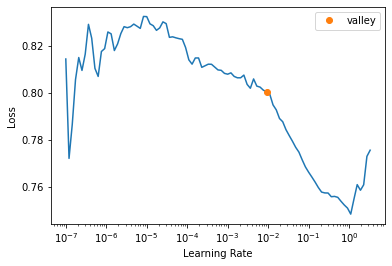

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.589405,0.563011,0.696726,01:16


In [17]:
preds, y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds,y)
print('The accuracy is {0}%.'.format(acc))

The accuracy is 0.6967263221740723%.


In [18]:
learn.show_results()

,roof,era,home,down,qtr,game_half,score_diff,wp,vegas_wp,ydstogo,yardline_100,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type,play_type_pred
0,4.0,3.0,2.0,1.0,1.0,1.0,0.141785,0.501801,-0.055274,0.364163,-0.115629,0.905162,0.586965,0.591630,1.0,1.0
1,4.0,2.0,2.0,3.0,1.0,1.0,0.790384,0.939739,0.046079,-1.169322,-0.973709,1.023523,0.586965,0.591630,0.0,0.0
2,4.0,1.0,2.0,2.0,1.0,1.0,-0.506813,-0.637560,-1.084649,-0.658161,1.273644,0.614806,0.586965,0.591630,0.0,1.0
3,4.0,3.0,2.0,2.0,1.0,1.0,-0.136185,0.397728,0.905298,-1.680484,-0.687683,0.109921,0.586965,-0.846550,1.0,1.0
4,4.0,1.0,2.0,1.0,1.0,1.0,0.512413,0.752808,0.258109,0.364163,-1.055431,0.694330,0.586965,0.591630,1.0,1.0
5,1.0,2.0,1.0,2.0,4.0,2.0,-0.784784,-1.511374,-1.412438,-0.402580,0.865034,-1.051501,0.586965,0.591630,0.0,0.0
6,4.0,1.0,2.0,2.0,1.0,1.0,0.141785,0.175388,0.813038,-0.146999,0.497286,1.680059,0.586965,0.591630,0.0,0.0
7,4.0,3.0,1.0,2.0,2.0,1.0,1.346326,1.292382,1.439087,-1.169322,-0.238212,-0.764845,-0.742094,-2.284729,1.0,1.0
8,4.0,1.0,2.0,1.0,4.0,2.0,-0.321499,-0.542838,-0.223655,0.364163,-0.605961,-1.071845,-0.742094,0.591630,0.0,0.0


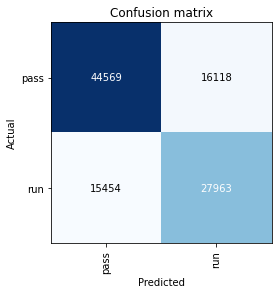

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [20]:
from sklearn.metrics import roc_curve, auc
probs = (preds[:,1])
# compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs)

# Compute ROC area
roc_auc = auc(fpr,tpr)
print(f'ROC area is {roc_auc}')

ROC area is 0.7673810471440954


In [21]:
print(preds)
print(probs)

tensor([[0.4948, 0.5052],
        [0.7047, 0.2953],
        [0.6957, 0.3043],
        ...,
        [0.4128, 0.5872],
        [0.5518, 0.4482],
        [0.4348, 0.5652]])
tensor([0.5052, 0.2953, 0.3043,  ..., 0.5872, 0.4482, 0.5652])


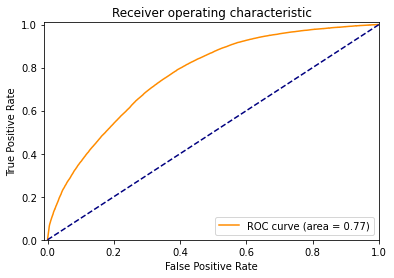

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


In [23]:
test_df = df.copy()
test_df.drop(['play_type'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)
preds = learn.get_preds(dl=dl)

In [24]:
df['xp'] = preds[0][:,0]

In [25]:

df['play_type_class'] = np.select([df['play_type'] == 'pass', df['play_type'] == 'run'],[1,0], default=0)

df['bin_pred_prob'] = round(df['xp'] / 0.05) * 0.05

df['situation'] = np.select([((df.down == 1) & (df.ydstogo == 10)),
                             (df.down == 2),
                             (df.down == 3)],
                            ['1st & 10', '2nd down', '3rd down'], default = 'Other')
df_xp=(df.groupby(['situation', 'bin_pred_prob']).agg({'play_type_class':[('n_plays','count'),('n_complete', 'sum')]})
 .droplevel(level=0, axis=1)
 .reset_index()
 .assign(bin_actual_prob= lambda x: x.n_complete / x.n_plays)
)
df_xp

,situation,bin_pred_prob,n_plays,n_complete,bin_actual_prob
0,1st & 10,0.15,7859,663,0.084362
1,1st & 10,0.20,2484,507,0.204106
2,1st & 10,0.25,2937,707,0.240722
3,1st & 10,0.30,3728,1102,0.295601
4,1st & 10,0.35,6459,2158,0.334107
...,...,...,...,...,...
67,Other,0.80,1001,866,0.865135
68,Other,0.85,1083,942,0.869806
69,Other,0.90,2252,2029,0.900977
70,Other,0.95,1288,1239,0.961957


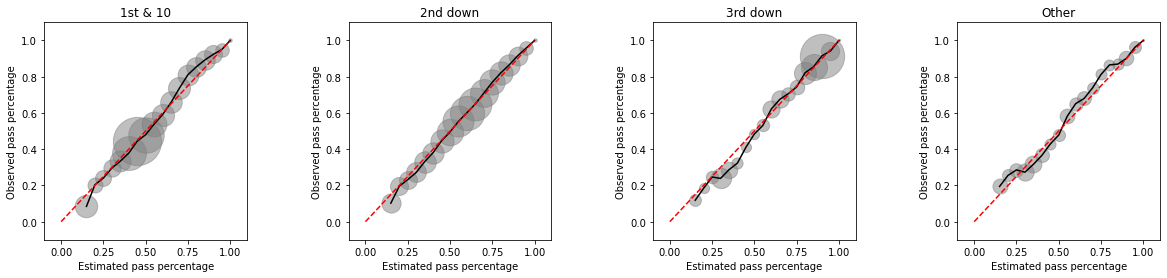

In [26]:
# -- have yet to implement -- from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = (0,1)
        low_y, high_y = (0,1)
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


fig, ax = subplots(1,4, figsize=(20,4))
fig.subplots_adjust(wspace=0.5)
for idx, situation in enumerate(df_xp.situation.unique()):
    for row_idx, row in df_xp[df_xp.situation == situation].iterrows():
        ax[idx].scatter(x=row.bin_pred_prob, y=row.bin_actual_prob, s=2**np.log(row.n_plays), alpha=0.5,color='grey')
    ax[idx].plot('bin_pred_prob', 'bin_actual_prob', data=df_xp[df_xp.situation == situation], color='k')
    add_identity(ax[idx], color='r', ls='--')
    ax[idx].set_title(situation)
    ax[idx].set_xlim([-0.1,1.1])
    ax[idx].set_ylim([-0.1,1.1])
    ax[idx].set_xlabel('Estimated pass percentage')
    ax[idx].set_ylabel('Observed pass percentage')
    

plt.show()

In [27]:
# Calculate error between expected and observed

wm = lambda x: np.average(x, weights=df_xp.loc[x.index, "n_plays"])

df_xp['cal_diff'] = abs(df_xp.bin_pred_prob - df_xp.bin_actual_prob)
xp_cv_cal_error = df_xp.groupby('situation').agg(n_complete=('n_complete','sum'),weighted_cal_error=('cal_diff',wm))
round(np.average(xp_cv_cal_error.weighted_cal_error, weights=xp_cv_cal_error.n_complete),4)


0.0165

In [28]:
# https://www.opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/#expected-pass-model-calibration-results
# model calibration of NFLverse  Expected Pass Model is 0.008

In [29]:
# explore why 3rd down is a problem for the model
xp_range = (df.xp > .25)&(df.xp < .75)
on_3rd_down = (df.down == 3)

df[xp_range & on_3rd_down]

,play_type,roof,era,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,vegas_wp,xp,play_type_class,bin_pred_prob,situation
57,pass,outdoors,2.0,-3.0,1,3.0,2.0,66.0,Half1,2.0,460.0,3.0,2.0,0.510377,0.549090,0.603314,1,0.60,3rd down
77,pass,outdoors,2.0,3.0,0,3.0,2.0,34.0,Half1,2.0,37.0,1.0,3.0,0.627846,0.549294,0.748892,1,0.75,3rd down
119,run,outdoors,2.0,7.0,0,3.0,1.0,41.0,Half2,3.0,1059.0,2.0,3.0,0.804834,0.778743,0.313173,0,0.30,3rd down
154,run,outdoors,2.0,14.0,0,3.0,12.0,82.0,Half2,4.0,339.0,2.0,2.0,0.987814,0.979440,0.605397,0,0.60,3rd down
257,run,outdoors,2.0,-17.0,1,3.0,20.0,78.0,Half1,2.0,54.0,0.0,1.0,0.073967,0.092827,0.641419,0,0.65,3rd down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794390,pass,outdoors,4.0,-8.0,1,3.0,1.0,70.0,Half2,3.0,1437.0,3.0,3.0,0.243900,0.493477,0.321442,1,0.30,3rd down
794393,pass,outdoors,4.0,-8.0,1,3.0,2.0,48.0,Half2,3.0,1320.0,3.0,3.0,0.255741,0.503107,0.637235,1,0.65,3rd down
794448,run,outdoors,4.0,0.0,1,3.0,1.0,55.0,Half2,4.0,68.0,3.0,2.0,0.684787,0.773291,0.394885,0,0.40,3rd down
794470,pass,outdoors,4.0,0.0,1,3.0,1.0,49.0,Overtime,5.0,424.0,2.0,2.0,0.592451,0.592451,0.259682,1,0.25,3rd down


In [30]:
# test LeaveOneGroupOut (season) validation 
# from sklearn.model_selection import LeaveOneGroupOut, train_test_split

# train, test  = train_test_split(df, test_size=0.2)

# val_pct, tst_preds = L(), L()
# logo = LeaveOneGroupOut()
# logo.get_n_splits(groups=train.season)

# for train_idx, valid_idx in logo.split(train.index,  train['play_type'], groups=train.season): # right here
#     splits = (L(list(train_idx)), L(list(valid_idx)))
#     procs = [Categorify, Normalize, FillMissing]
#     to = TabularPandas(train, procs, cat_names, cont_names, y_names='play_type',
#                        splits=splits)
#     dls = to.dataloaders(bs=512)
#     learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
#     learn.fit(3, 1e-2)
#     test_dl = learn.dls.test_dl(test)
#     with learn.no_bar():
#         val_pct.append(learn.validate()[-1])
#         tst_preds.append(learn.get_preds(dl=test_dl))
# for i, (pred, truth) in enumerate(tst_preds):
#     print(f'Fold {i+1}: {accuracy(pred, truth)}')
# sum_preds = []
# for i, (pred, truth) in enumerate(tst_preds):
#     sum_preds.append(pred.numpy())
# avg_preds = np.sum(sum_preds, axis=0) / 16
# print(f'Average Accuracy: {accuracy(tensor(avg_preds), tst_preds[0][1])}')